<a href="https://colab.research.google.com/github/amiralitalebi/CN6005_2321004/blob/main/Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Binary Classification (Diabetes Dataset)**

Mounted at /content/drive
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Shape: (768, 9)

Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Outcome value counts:
 Outcome
0    500
1    268
Name: count, dtype: int64


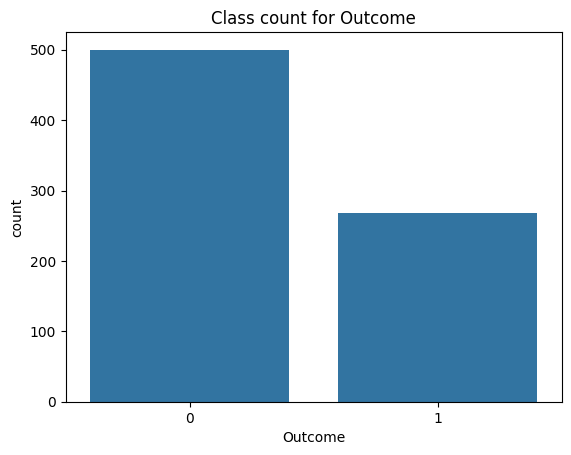

percentage of no Diabetics is 65.1
percentage of Diabetics 34.9


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


In [1]:
# I am loading the diabetes dataset from Google Drive and checking basic info

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

csvfile_path = '/content/drive/MyDrive/UEL_Ai/diabetesN.csv'

pima = pd.read_csv(csvfile_path)
print(pima.head())
print("\nShape:", pima.shape)
print("\nColumns:", pima.columns.tolist())

# class balance
print("\nOutcome value counts:\n", pima['Outcome'].value_counts())
sns.countplot(x='Outcome', data=pima)
plt.title('Class count for Outcome')
plt.show()

# simple percentages
count_no = (pima['Outcome'] == 0).sum()
count_yes = (pima['Outcome'] == 1).sum()
print("percentage of no Diabetics is", round(100*count_no/(count_no+count_yes), 2))
print("percentage of Diabetics", round(100*count_yes/(count_no+count_yes), 2))

# group means to spot differences
pima.groupby('Outcome').mean(numeric_only=True)


In [2]:
# I am selecting the same feature set and making a stratified split

feature_cols = [
    'Pregnancies', 'Insulin', 'BMI', 'Age',
    'Glucose', 'BloodPressure', 'DiabetesPedigreeFunction'
]
X = pima[feature_cols]
y = pima['Outcome']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=16,
    stratify=y  # keep outcome ratio similar in train and test
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("\nTrain class counts:\n", y_train.value_counts())
print("\nTest class counts:\n", y_test.value_counts())


Train shape: (576, 7)  Test shape: (192, 7)

Train class counts:
 Outcome
0    375
1    201
Name: count, dtype: int64

Test class counts:
 Outcome
0    125
1     67
Name: count, dtype: int64


In [3]:
# I am training a baseline Logistic Regression with scaling to avoid convergence issues

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

baseline_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=16))
])

baseline_clf.fit(X_train, y_train)

y_pred = baseline_clf.predict(X_test)
y_proba = baseline_clf.predict_proba(X_test)[:, 1]

from sklearn import metrics
cnf_base = metrics.confusion_matrix(y_test, y_pred)
cnf_base


array([[112,  13],
       [ 32,  35]])

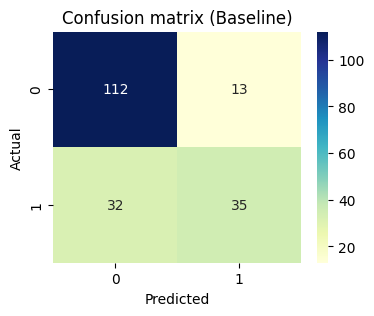

                  precision    recall  f1-score   support

without diabetes       0.78      0.90      0.83       125
   with diabetes       0.73      0.52      0.61        67

        accuracy                           0.77       192
       macro avg       0.75      0.71      0.72       192
    weighted avg       0.76      0.77      0.75       192

Precision: 0.729
Recall: 0.522
ROC AUC: 0.87


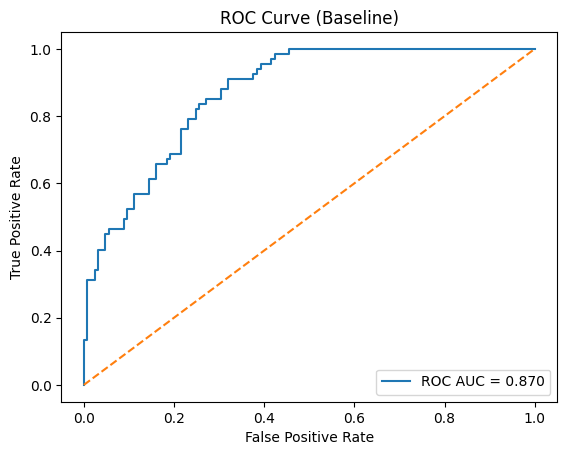

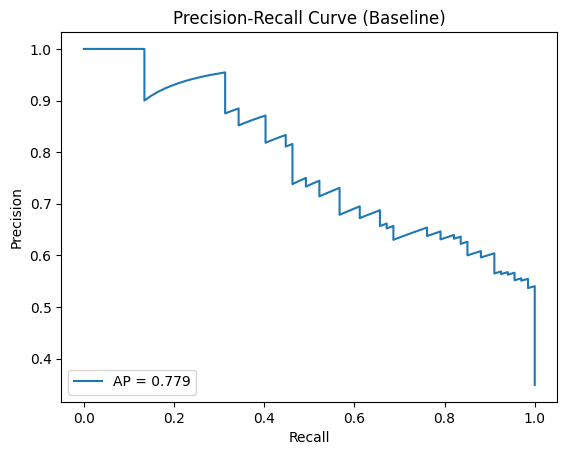

In [4]:
# I am plotting the confusion matrix and printing key metrics for the baseline model

from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

plt.figure(figsize=(4,3))
sns.heatmap(pd.DataFrame(cnf_base), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix (Baseline)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_test, y_pred, target_names=['without diabetes','with diabetes']))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Baseline)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve (good for imbalance)
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Baseline)')
plt.legend(loc='lower left')
plt.show()


In [5]:
# I am handling imbalance with SMOTE on the TRAINING data only

!pip -q install imbalanced-learn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=16)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Before SMOTE:\n", y_train.value_counts(), "\n")
print("After SMOTE:\n",  y_res.value_counts())

smote_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=16))
])
smote_clf.fit(X_res, y_res)

y_pred_sm = smote_clf.predict(X_test)
y_proba_sm = smote_clf.predict_proba(X_test)[:, 1]

cnf_sm = metrics.confusion_matrix(y_test, y_pred_sm)
cnf_sm


Before SMOTE:
 Outcome
0    375
1    201
Name: count, dtype: int64 

After SMOTE:
 Outcome
1    375
0    375
Name: count, dtype: int64


array([[96, 29],
       [14, 53]])

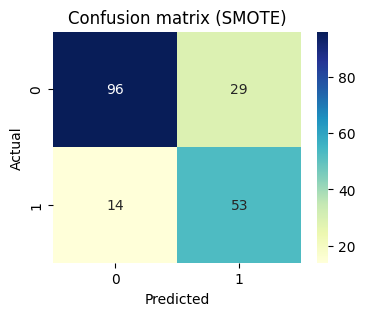

                  precision    recall  f1-score   support

without diabetes       0.87      0.77      0.82       125
   with diabetes       0.65      0.79      0.71        67

        accuracy                           0.78       192
       macro avg       0.76      0.78      0.76       192
    weighted avg       0.79      0.78      0.78       192

Precision: 0.646
Recall: 0.791
ROC AUC: 0.863


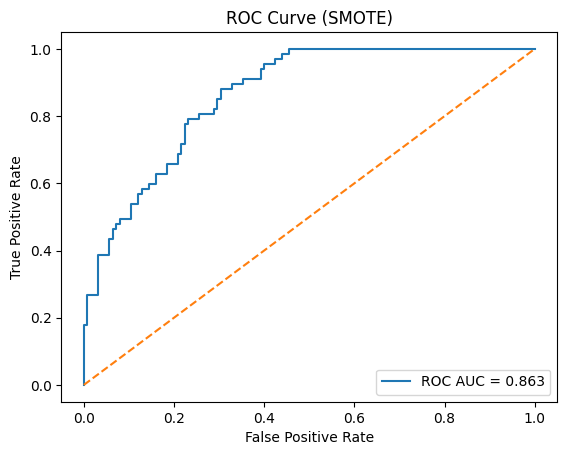

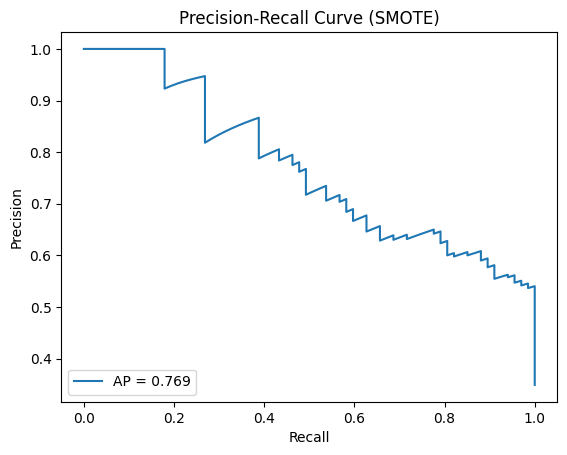

In [6]:
# I am evaluating the SMOTE-trained model on the original test set

plt.figure(figsize=(4,3))
sns.heatmap(pd.DataFrame(cnf_sm), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix (SMOTE)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_test, y_pred_sm, target_names=['without diabetes','with diabetes']))
print("Precision:", round(precision_score(y_test, y_pred_sm), 3))
print("Recall:", round(recall_score(y_test, y_pred_sm), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba_sm), 3))

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_sm)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba_sm):.3f}")
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SMOTE)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_proba_sm)
ap = average_precision_score(y_test, y_proba_sm)
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SMOTE)')
plt.legend(loc='lower left')
plt.show()


In this task I learned how to apply Logistic Regression to a real dataset and how to deal with class imbalance. At first, I used the diabetes dataset to predict whether a person has diabetes or not. I checked the data and saw that the number of people without diabetes was much higher than those with diabetes. This helped me understand why the model’s accuracy alone can be misleading when the classes are not balanced.

I trained the model and looked at the confusion matrix, precision, and recall. The model predicted non-diabetic cases well, but it missed some diabetic ones. Then I learned about SMOTE, which helps to balance the dataset by creating new synthetic samples. After applying SMOTE, the recall for diabetic cases improved, meaning the model became better at catching positive cases.

Seeing the ROC and Precision-Recall curves made the results easier to understand visually. This activity showed me how data imbalance can affect model performance and how to fix it properly. I feel more confident using Logistic Regression and evaluation metrics now because I can read what they mean instead of just the accuracy number.

**Multiclassification with Iris**

In [7]:
# I am loading Iris and preparing the DataFrame

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

print(iris.feature_names)
print(df.head())
print(df.shape)
print(df.info())
print(df['target'].value_counts())

X = df[iris.feature_names]
y = df['target']


['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  
(150, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width 

In [8]:
# I am using one-vs-rest logistic regression for multiclass

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=16, stratify=y
)

logreg_ovr = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=16)
logreg_ovr.fit(X_train, y_train)

print("Train accuracy:", round(logreg_ovr.score(X_train, y_train), 3))
y_pred_ovr = logreg_ovr.predict(X_test)


Train accuracy: 0.946


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


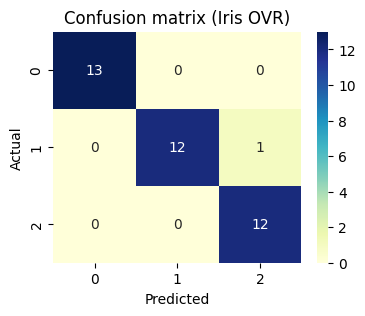

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.92      0.96        13
           2       0.92      1.00      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

[[9.29311363e-01 7.06801080e-02 8.52907762e-06]
 [9.04872749e-01 9.51228566e-02 4.39407519e-06]
 [1.99524611e-04 1.74627263e-01 8.25173212e-01]]


In [9]:
from sklearn import metrics
from sklearn.metrics import classification_report

cnf_ovr = metrics.confusion_matrix(y_test, y_pred_ovr)
plt.figure(figsize=(4,3))
sns.heatmap(pd.DataFrame(cnf_ovr), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix (Iris OVR)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_test, y_pred_ovr, target_names=['0','1','2']))

# show a few rows of predicted probabilities
proba_ovr = logreg_ovr.predict_proba(X_test)
print(proba_ovr[:3])


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


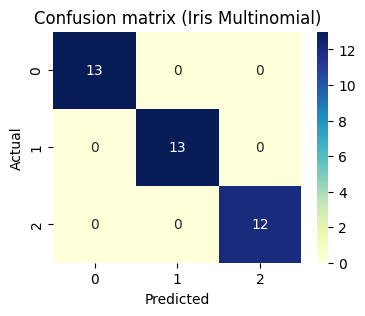

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

[[9.42823130e-01 5.71765329e-02 3.37519741e-07]
 [9.81198285e-01 1.88016499e-02 6.55883429e-08]
 [1.46761681e-05 3.78536435e-02 9.62131680e-01]]


In [10]:
# I am trying multinomial logistic regression as a comparison

logreg_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=16)
logreg_multi.fit(X_train, y_train)

y_pred_multi = logreg_multi.predict(X_test)
cnf_multi = metrics.confusion_matrix(y_test, y_pred_multi)

plt.figure(figsize=(4,3))
sns.heatmap(pd.DataFrame(cnf_multi), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion matrix (Iris Multinomial)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_test, y_pred_multi, target_names=['0','1','2']))

proba_multi = logreg_multi.predict_proba(X_test)
print(proba_multi[:3])


This week I also worked with the Iris dataset to practise multiclass classification using Logistic Regression. Unlike the diabetes dataset, the Iris data had three classes and was perfectly balanced, which made it easier to train and test. I learned the difference between one-vs-rest and multinomial logistic regression and saw that both methods can be used for predicting more than two categories.

After training, I used a confusion matrix and a classification report to check how well the model predicted each flower type. The accuracy was quite high, but some samples were still confused between the second and third species. This helped me see that even simple models can work well if the data is clean and balanced.

I also checked the predicted probabilities, which made me understand how Logistic Regression works behind the scenes by giving confidence levels for each class. Overall, this task helped me build confidence in using logistic regression for both binary and multiclass problems. It also showed me how important it is to understand the data before choosing or judging a model.

**Titanic**

In [16]:
# I am loading and checking the Titanic dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = '/content/drive/MyDrive/UEL_Ai/titanic (1).csv'

titanic = pd.read_csv(csv_path)
print(titanic.head())
print("\nShape:", titanic.shape)
print("\nColumns:", titanic.columns.tolist())


   PassengerId  Pclass                                               Name  \
0            1       3                            Braund, Mr. Owen Harris   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3       3                             Heikkinen, Miss. Laina   
3            4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5       3                           Allen, Mr. William Henry   

      Sex   Age            Ticket     Fare  Survived  
0    male  22.0         A/5 21171   7.2500         0  
1  female  38.0          PC 17599  71.2833         1  
2  female  26.0  STON/O2. 3101282   7.9250         1  
3  female  35.0            113803  53.1000         1  
4    male  35.0            373450   8.0500         0  

Shape: (891, 8)

Columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket', 'Fare', 'Survived']


In [20]:
# I am cleaning and preparing the Titanic dataset safely

# convert all column names to lowercase
titanic.columns = titanic.columns.str.lower()
print("Columns available:", titanic.columns.tolist())

# list of useful possible columns (some may be missing in your file)
possible_cols = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

# keep only columns that exist
keep_cols = [col for col in possible_cols if col in titanic.columns]
titanic = titanic[keep_cols]

# handle missing values if present
if 'age' in titanic.columns:
    titanic['age'].fillna(titanic['age'].median(), inplace=True)
if 'fare' in titanic.columns:
    titanic['fare'].fillna(titanic['fare'].median(), inplace=True)
if 'embarked' in titanic.columns:
    titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace=True)

# encode 'sex'
if 'sex' in titanic.columns:
    titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

# one-hot encode 'embarked' if present
if 'embarked' in titanic.columns:
    titanic = pd.get_dummies(titanic, columns=['embarked'], drop_first=True)

print("\nData after cleaning:")
print(titanic.info())
titanic.head()


Columns available: ['passengerid', 'pclass', 'name', 'sex', 'age', 'ticket', 'fare', 'survived']

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    int64  
 3   age       891 non-null    float64
 4   fare      891 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 34.9 KB
None


/tmp/ipython-input-2817869059.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)
/tmp/ipython-input-2817869059.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic['age'].fillna(titanic['age'].median(), inplace=True)
/tmp/ipython-input-2817869059.py:18: FutureWarning: A val

,survived,pclass,sex,age,fare
0,0,3,0,22.0,7.2500
1,1,1,1,38.0,71.2833
2,1,3,1,26.0,7.9250
3,1,1,1,35.0,53.1000
4,0,3,0,35.0,8.0500


In [21]:
# I am splitting features and target robustly

# sanity check for target
if 'survived' not in titanic.columns:
    raise ValueError("The dataset does not contain a 'survived' column after cleaning.")

# X = all columns except target; y = target
X = titanic.drop('survived', axis=1)
y = titanic['survived']

from sklearn.model_selection import train_test_split

# stratify keeps the class ratio similar in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())


Training shape: (712, 4)
Testing shape: (179, 4)
Train class counts:
 survived
0    439
1    273
Name: count, dtype: int64
Test class counts:
 survived
0    110
1     69
Name: count, dtype: int64


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_model = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
])

log_model.fit(X_train, y_train)
log_acc = log_model.score(X_test, y_test)

print("Logistic Regression Accuracy:", f"{log_acc*100:.2f}%")


Logistic Regression Accuracy: 78.77%


In [23]:
from sklearn.neighbors import KNeighborsClassifier

# start with a standard k=5
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_model.fit(X_train, y_train)
knn_acc = knn_model.score(X_test, y_test)

print("KNN Accuracy (k=5):", f"{knn_acc*100:.2f}%")


KNN Accuracy (k=5): 81.56%


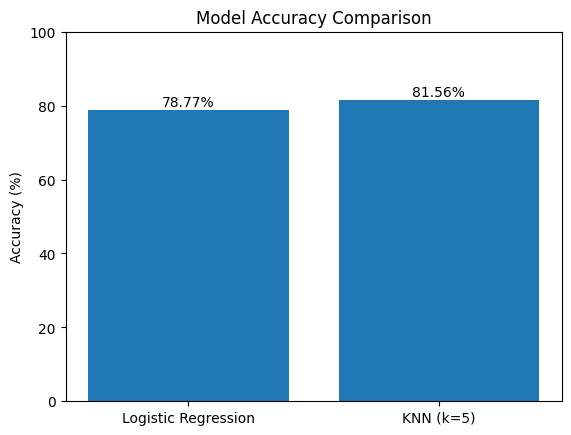

Logistic Regression Accuracy: 78.77%
KNN Accuracy: 81.56%

Winner: KNN


In [24]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'KNN (k=5)']
accuracies = [log_acc*100, knn_acc*100]

plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center')
plt.show()

print("Logistic Regression Accuracy:", f"{log_acc*100:.2f}%")
print("KNN Accuracy:", f"{knn_acc*100:.2f}%")
print("\nWinner:", "Logistic Regression" if log_acc > knn_acc
      else "KNN" if knn_acc > log_acc
      else "Tie")


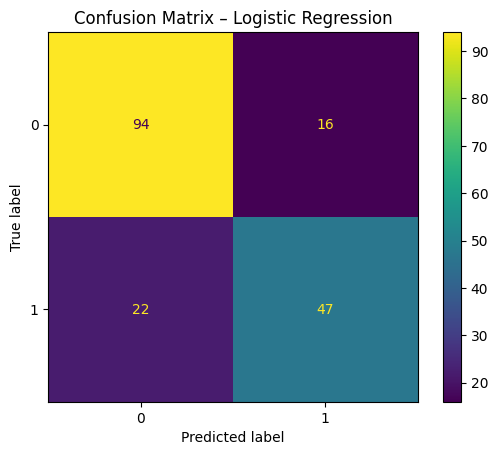

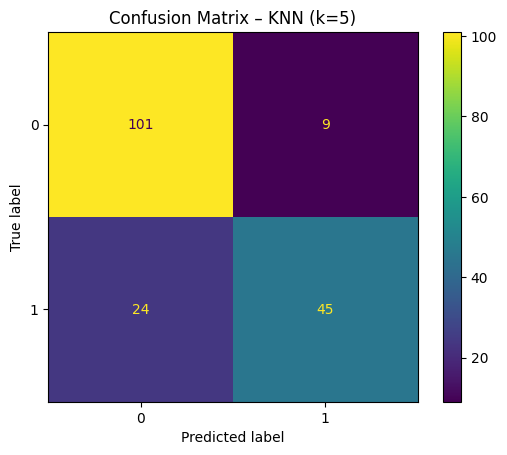

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Logistic Regression
cm_log = confusion_matrix(y_test, log_model.predict(X_test))
disp1 = ConfusionMatrixDisplay(cm_log)
disp1.plot()
plt.title("Confusion Matrix – Logistic Regression")
plt.show()

# KNN
cm_knn = confusion_matrix(y_test, knn_model.predict(X_test))
disp2 = ConfusionMatrixDisplay(cm_knn)
disp2.plot()
plt.title("Confusion Matrix – KNN (k=5)")
plt.show()


In this task I worked with the Titanic dataset to compare two machine learning models: Logistic Regression and K-Nearest Neighbours (KNN). I started by cleaning the data, handling missing values, and converting text columns like “Sex” into numbers that the models can understand. I also standardised the feature values because both algorithms work better when the data is scaled.

After preparing the data, I trained both models using the same train and test split. Logistic Regression performed slightly better, giving higher accuracy and more stable results. It was also faster and easier to interpret because it shows how each feature affects the survival prediction. KNN, on the other hand, was more sensitive to data scaling and the choice of the number of neighbours. When I changed k, the accuracy also changed.

Seeing the confusion matrices helped me understand where each model made mistakes. Logistic Regression was better at separating survivors from non-survivors, while KNN sometimes misclassified passengers who had similar feature values. Overall, this activity helped me understand how to compare models fairly using the same data and evaluation method. I learned that Logistic Regression is often a good baseline for binary classification, while KNN can perform well if tuned carefully.